In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import os

from adaptable import AdaptableNet

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.set_device(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Set seed properly
np.random.seed(1)
torch.manual_seed(1)

# Create the AdaptableNet
test_net = AdaptableNet(device, 12, 5, hidden_size=[7, 10]).to(device)
# Create some fake data
test_data = torch.Tensor(np.random.random((4, 12))).to(device)
# Generate some fake output
test_output = test_net(test_data)

# Increase the size of the first hidden layer of the net
test_net.increase_hidden_size(0)

print("Difference After Increase 1:", torch.norm(test_output - test_net(test_data)))

# Immediately decrease the size of the first hidden layer of the net 
# Note: this first decrease will be a trivial operation since we are just undoing the increase from above
test_net.decrease_hidden_size(0)

print("Difference After Decrease 1:", torch.norm(test_output - test_net(test_data)))

# Decrease the size of the first hidden layer of the net AGAIN. 
# This will be a nontrivial decrease, as it has to get rid of some nonzero weights
test_net.decrease_hidden_size(0)

print("Difference After Decrease 2:", torch.norm(test_output - test_net(test_data)))

Difference After Increase 1: tensor(0., device='cuda:0', grad_fn=<CopyBackwards>)
Difference After Decrease 1: tensor(0.0399, device='cuda:0', grad_fn=<CopyBackwards>)
Difference After Decrease 2: tensor(0.0399, device='cuda:0', grad_fn=<CopyBackwards>)


Experiment 1: Seeing what method of decreasing the hidden size is in general best. May need to come back to try new methods of doing this since the current methods are very heuristic.

In [6]:
# Will store our "losses" for each mode
losses = np.zeros((4, 1000))

# For different seeds
for i in range(1000):
    # For each mode
    for mode in range(4):
        # Set the seeds
        np.random.seed(i)
        torch.manual_seed(i)
        # Initialize Net
        test_net = AdaptableNet(device, 12, 5, hidden_size=[10,])
        # Generate data
        test_data = torch.Tensor(np.random.random((4, 12))).to(device)
        # Generate output
        test_output = test_net(test_data)
        # Decrease the size
        test_net.decrease_hidden_size(0, mode=mode)
        # Compute the norm of the difference in the output
        losses[mode, i] = torch.norm(test_output - test_net(test_data))
        
means = np.mean(losses, axis=1)
print("Method 0 avg. loss:", means[0])
print("Method 1 avg. loss:", means[1])
print("Method 2 avg. loss:", means[2])
print("Method 3 avg. loss:", means[3])

Method 0 avg. loss: 0.3508608553572558
Method 1 avg. loss: 0.08565819954313338
Method 2 avg. loss: 0.08222294467076427
Method 3 avg. loss: 0.35852245862683046


Experiment #2 Control Tests for our network. Testing a variety of different static sizes, to see what our algorithm "should" converge to.

In [3]:
from torchvision.datasets import MNIST, EMNIST, QMNIST, KMNIST, FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
matplotlib.style.use('seaborn')
#rc('text', usetex=True)
rc('font', family='serif')
import seaborn as sns
sns.set_palette('Paired')

In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\alexg\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [154]:
# Tensorize everything
tensor_transform = transforms.Compose([
    transforms.ToTensor()
])
# Load QMNIST (digits)
train_data = QMNIST('./data/', download=True, train=True, transform=tensor_transform)
test_data = QMNIST('./data/', download=True, train=False, transform=tensor_transform)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True, num_workers=8)
test_loader = DataLoader(test_data, batch_size=256, shuffle=True, num_workers=8)

In [43]:
def train_static_model(device, model, train_loader, test_loader, teststep = 125, eps=2e-4, logging = True):

    # Loss and optimizer
    criterion = nn.NLLLoss() #You can modify the loss function
    optimizer = optim.Adam(model.parameters(), lr=0.01) #You can change the optimizer

    # This is the moving average window of the test accuracy we compute to determine convergence.
    avg_window = 5
    num_epochs = 30

    # Train the model
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    test_acc = []

    epoch = 0
    converged = False
    for i in range(num_epochs):
        total = 0
        correct = 0
        for i, (images, labels) in enumerate(train_loader):

            images = images.cuda(non_blocking=True) #Transfer images to GPU
            labels = labels.cuda(non_blocking=True) #Transfer labels to GPU
            images = images.reshape((images.shape[0], images.shape[2] * images.shape[3]))

            images = Variable(images)
            labels = Variable(labels)
            # Run the forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())

            # Backprop 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

             # Track the accuracy
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

            if (i + 1) % teststep == 0:
                w = torch.nn.utils.parameters_to_vector(model.parameters())
                correct_test = 0
                total_test = 0
                for images_test, labels_test in test_loader:
                    images_test = images_test.cuda(non_blocking=True)
                    labels_test = labels_test.cuda(non_blocking=True)
                    images_test = images_test.reshape((images_test.shape[0], images_test.shape[2] * images_test.shape[3]))
                    images_test = Variable(images_test)
                    labels_test = Variable(labels_test)

                    outputs_test = model(images_test)
                    _, predicted_test = torch.max(outputs_test.data, 1)
                    total_test += labels_test.size(0)
                    correct_test += (predicted_test == labels_test).sum().item()
                # Don't print test accuracy, but use the results to plot the data
                test_acc.append(correct_test/total_test)
                
                # Test for convergence by comparing current accuracy with moving average of previous 5 test accuracies.
                if len(test_acc) > 5 and abs(test_acc[-1] - sum(test_acc[-6:-1]) / avg_window) < 2e-4:
                    converged = True
                if logging: 
                    print('Epoch [{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                          .format(epoch + 1, i + 1, total_step, loss.item(),
                                  (correct / total) * 100))

        acc_list.append(correct / total)
        epoch += 1

    return acc_list, test_acc, loss_list, epoch

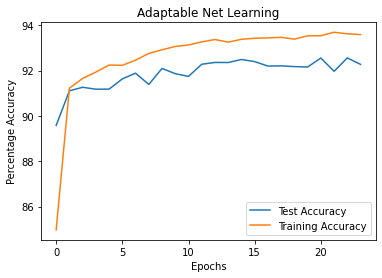

Test Acc: 0.9227333333333333, Train Acc: 0.9358833333333333, Epoch Converged: 24


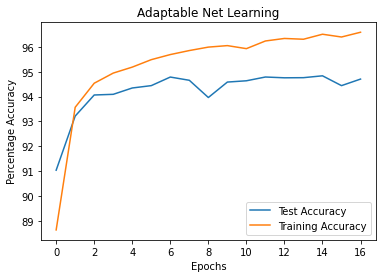

Test Acc: 0.9470333333333333, Train Acc: 0.9658833333333333, Epoch Converged: 17


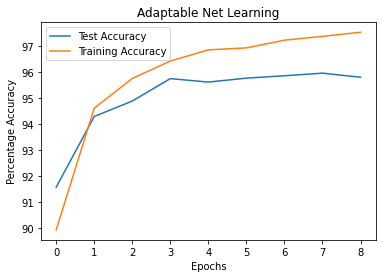

Test Acc: 0.9581, Train Acc: 0.9754, Epoch Converged: 9


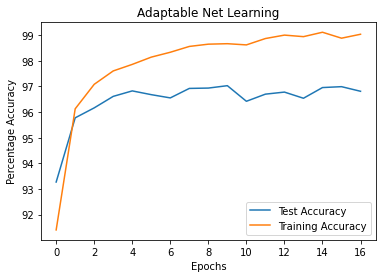

Test Acc: 0.9681, Train Acc: 0.9903333333333333, Epoch Converged: 17


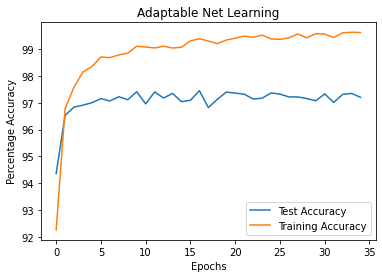

Test Acc: 0.9720166666666666, Train Acc: 0.99615, Epoch Converged: 35


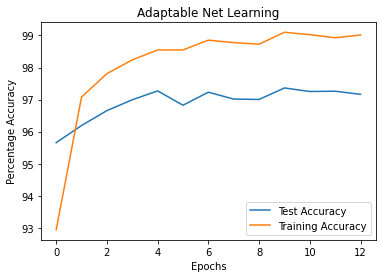

Test Acc: 0.9716333333333333, Train Acc: 0.9901333333333333, Epoch Converged: 13


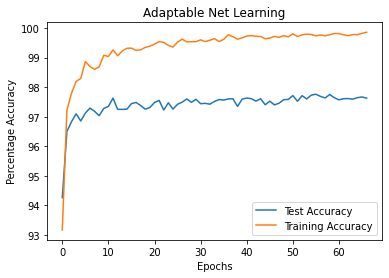

Test Acc: 0.9762666666666666, Train Acc: 0.99855, Epoch Converged: 67


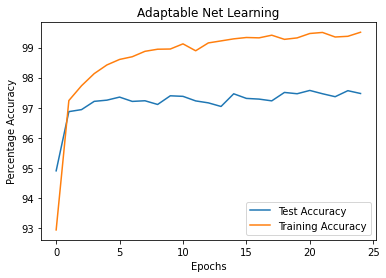

Test Acc: 0.9747166666666667, Train Acc: 0.9951, Epoch Converged: 25


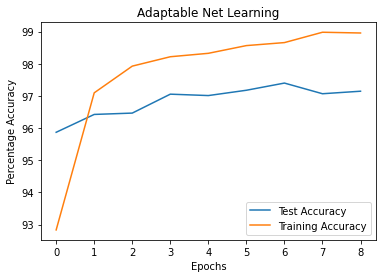

Test Acc: 0.9714666666666667, Train Acc: 0.9895666666666667, Epoch Converged: 9


In [41]:
results = {}
# For a variety of different hidden sizes
for i in range(3,12):
    plt.clf()
    hs =  2 ** i
    model = AdaptableNet(device, 784, 10, hidden_size=[hs]).to(device)
    acc_list, test_acc, loss_list, epoch = train_static_model(device, model, train_loader, test_loader, logging=False)
    plt.plot(range(len(test_acc)),[x * 100 for x in test_acc],label='Test Accuracy')
    plt.plot(range(len(acc_list)),[x * 100 for x in acc_list],label='Training Accuracy')
    plt.legend()
    plt.title("Adaptable Net Learning")
    plt.xlabel('Epochs')
    plt.ylabel('Percentage Accuracy')
    plt.show()
    print("Test Acc: {}, Train Acc: {}, Epoch Converged: {}".format(test_acc[-1], acc_list[-1], epoch))
    # Save the results so we can plot for later
    results[i] = (acc_list, test_acc, loss_list, epoch)

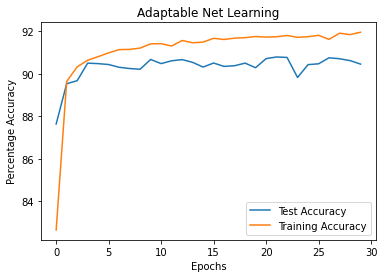

Test Acc: 0.9045833333333333, Train Acc: 0.9195666666666666, Epoch Converged: 30


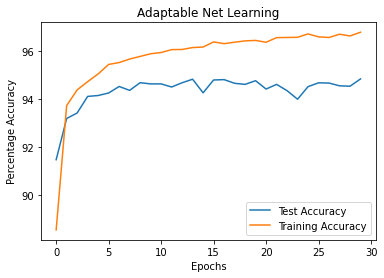

Test Acc: 0.9484, Train Acc: 0.9679, Epoch Converged: 30


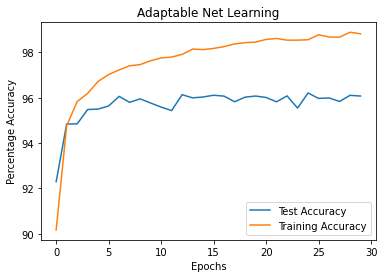

Test Acc: 0.96075, Train Acc: 0.9882, Epoch Converged: 30


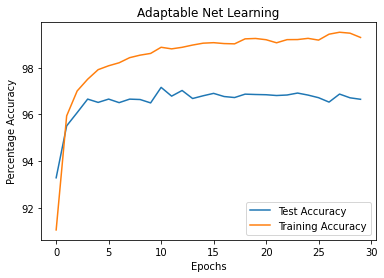

Test Acc: 0.9664666666666667, Train Acc: 0.9929333333333333, Epoch Converged: 30


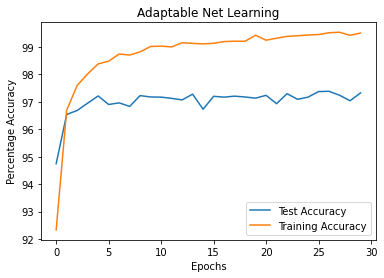

Test Acc: 0.97325, Train Acc: 0.9950666666666667, Epoch Converged: 30


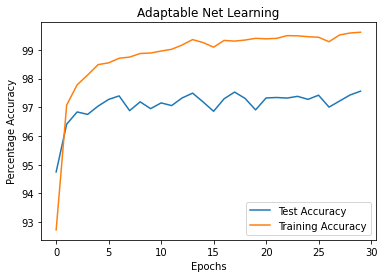

Test Acc: 0.9756, Train Acc: 0.9961166666666667, Epoch Converged: 30


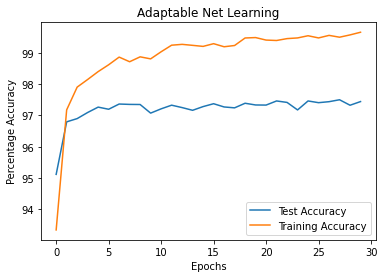

Test Acc: 0.9744166666666667, Train Acc: 0.99655, Epoch Converged: 30


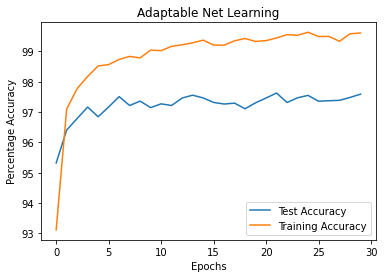

Test Acc: 0.9759166666666667, Train Acc: 0.9961, Epoch Converged: 30


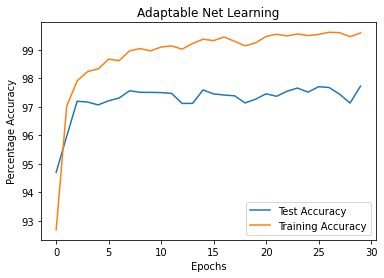

Test Acc: 0.9773, Train Acc: 0.9959166666666667, Epoch Converged: 30


In [44]:
# Now we do for a fixed # of epochs
results1 = {}
# For a variety of different hidden sizes
for i in range(3,12):
    plt.clf()
    hs =  2 ** i
    model = AdaptableNet(device, 784, 10, hidden_size=[hs]).to(device)
    acc_list, test_acc, loss_list, epoch = train_static_model(device, model, train_loader, test_loader, logging=False)
    plt.plot(range(len(test_acc)),[x * 100 for x in test_acc],label='Test Accuracy')
    plt.plot(range(len(acc_list)),[x * 100 for x in acc_list],label='Training Accuracy')
    plt.legend()
    plt.title("Adaptable Net Learning")
    plt.xlabel('Epochs')
    plt.ylabel('Percentage Accuracy')
    plt.show()
    print("Test Acc: {}, Train Acc: {}, Epoch Converged: {}".format(test_acc[-1], acc_list[-1], epoch))
    # Save the results so we can plot for later
    results1[i] = (acc_list, test_acc, loss_list, epoch)

Experiment #3 The real algorithm

In [146]:
def is_converged(cur, prevs,as_int=False, z_score=1):
    std = np.std(prevs) * z_score
    if as_int:
        if cur - np.mean(prevs) < -std:
            return 1
        elif cur - np.mean(prevs) > std:
            return -1
        else: return 0
    else:
        # Converged if we are within one standard deviation of the prevs
        return abs(cur - np.mean(prevs)) < std

def train_dynamic_model(device, model, train_loader, test_loader, teststep = 50, num_epochs=20, eps=1e-2, logging = True):

    # Loss and optimizer
    criterion = nn.NLLLoss() #You can modify the loss function
    optimizer = optim.Adam(model.parameters(), lr=0.01) #You can change the optimizer

    # This is the moving average window of the test accuracy we compute to determine convergence.
    avg_window = 4

    # Train the model
    total_step = len(train_loader)
    loss_list = []
    acc_list = []
    
    test_acc = []
    test_loss = []
    model_size = []
    
    model_changes = []
    grad_list = []
    grad_dict = {}
    last_grad = 100
    
    # Will hold the train/test loss
    bests = []
    
    # Activate train mode
    model.train()

    epoch = 0
    converged = False
    acted = False
    for i in range(num_epochs):
        total = 0
        correct = 0
        temp_loss_list = []
        temp_acc_list = []
        temp_grad_list = []
        for i, (images, labels) in enumerate(train_loader):
            
            images = images.cuda(non_blocking=True) #Transfer images to GPU
            labels = labels.cuda(non_blocking=True) #Transfer labels to GPU
            images = images.reshape((images.shape[0], images.shape[2] * images.shape[3]))

            images = Variable(images)
            labels = Variable(labels)
            # Run the forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            temp_loss_list.append(loss.item())

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Look at the gradient
            normalized_grad = 0
            for p in model.parameters():
                normalized_grad += torch.norm(p.grad) ** 2
            normalized_grad /= sum([p.numel() for p in model.parameters()]) # Get the gradient per parameter
            temp_grad_list.append(normalized_grad.item())

             # Track the accuracy
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            temp_acc_list.append((correct / total) * 100)
            if (i + 1) % teststep == 0:
                w = torch.nn.utils.parameters_to_vector(model.parameters())
                correct_test = 0
                total_test = 0
                loss_test_temp = []
                for images_test, labels_test in test_loader:
                    images_test = images_test.cuda(non_blocking=True)
                    labels_test = labels_test.cuda(non_blocking=True)
                    images_test = images_test.reshape((images_test.shape[0], images_test.shape[2] * images_test.shape[3]))
                    images_test = Variable(images_test)
                    labels_test = Variable(labels_test)

                    outputs_test = model(images_test)
                    _, predicted_test = torch.max(outputs_test.detach(), 1)
                    total_test += labels_test.size(0)
                    correct_test += (predicted_test == labels_test).sum().item()
                    
                    loss_test_temp.append(criterion(outputs_test.detach(), labels_test).item())
                # Keep all of these results
                test_acc.append((correct_test/total_test) * 100)
                test_loss.append(np.mean(loss_test_temp))
                bests.append(min(test_loss))
                acc_list.append(np.mean(temp_acc_list[-10:]))
                temp_acc_list = []
                loss_list.append(np.mean(temp_loss_list))
                temp_loss_list = []
                
                model_size.append(sum([p.numel() for p in model.parameters()]))
                grad_list.append(np.mean(temp_grad_list))
                best_grad = min(grad_list)
                temp_grad_list = []
                if model.hidden_size[0] in grad_dict.keys():
                    grad_dict[model.hidden_size[0]] = min(grad_list[-1], grad_dict[model.hidden_size[0]])
                else:
                    grad_dict[model.hidden_size[0]] = grad_list[-1]
                
                # Test for convergence by comparing current accuracy with moving average of previous 3 test accuracies.
                if len(test_loss) <= avg_window + 1: # Initial condition
                    test_better = 1
                    train_better = 1
                    grad_better = 1
                else:
                    test_better = is_converged(test_loss[-1], test_loss[-(avg_window + 1):-1], as_int=True)
                    train_better = is_converged(loss_list[-1], loss_list[-(avg_window + 1):-1], as_int=True)
                    grad_better = is_converged(grad_list[-1], grad_list[-(avg_window + 1):-1], as_int=True, z_score=0.5)
                
                grad_converged = is_converged(grad_list[-1], grad_list[-(avg_window + 1):-1], z_score=0.5)
                
                # This is the size of the network when we achieved our best test loss
                target_size = model_size[bests.index(bests[-1])]
                in_best_test_range = is_converged(bests[-1], test_loss[-min(avg_window, len(test_loss)):])
                
                
                if logging:
                    print('Epoch [{}], Step [{}/{}], Train/Test Loss: {:.4f}/{:.4f}, Train/Test Accuracy: {:.2f}%/{:.2f}%'
                          .format(epoch + 1, i + 1, total_step, loss_list[-1], test_loss[-1], acc_list[-1], test_acc[-1]))
                
                # What % more loss does the test data have relative to train data? (Assume nonnegative)
                overfit_gap = max((test_loss[-1] - loss_list[-1])/ loss_list[-1], 0)    
                print(model.hidden_size, overfit_gap, grad_converged)
                
                
                if grad_converged:
                    if len(model_changes) == 0:
                        last_hidden_size = model.hidden_size[0]
                        last_grad = grad_list[-1]
                        for _ in range(8):
                            model.increase_hidden_size(0)
                        model_changes.append(1)
                    else:
                        # If we increased and it didn't give us significant improvement
                        if model_changes[-1] == 1 and (last_grad - grad_list[-1])/last_grad < .05:
                            # Shrink down the network
                            for _ in range(8):
                                model.decrease_hidden_size(0)
                            model_changes.append(-1)
                        # If we increased and there was significant improvement
                        elif model_changes[-1] == 1:
                            # Keep increasing 
                            for _ in range(8):
                                model.increase_hidden_size(0)
                            model_changes.append(1)
                        # If we decreased the network and the new grad isn't that much worse
                        elif model_changes[-1] == -1 and (grad_list[-1] - last_grad)/last_grad < 0.05:
                            # Keep shrinking
                            for _ in range(8):
                                model.decrease_hidden_size(0)
                            model_changes.append(-1)
                        # If we decreased the network and it was significantly worse
                        elif model_changes[-1] == -1:
                            # Re-increase the network
                            for _ in range(8):
                                model.increase_hidden_size(0)
                            model_changes.append(1)
                
                
                # Now that we just updated the model, we need to redeclare the optimizer
                optimizer = optim.Adam(model.parameters(), lr=0.01)
        epoch += 1

    return acc_list, test_acc, loss_list, test_loss, model_size, grad_list

In [ ]:
#results3 = {}
num_epochs = 15
hss = [16, 64, 256] # TODO: Add More
for hs in hss:
    for i in range(3):
        torch.manual_seed(i)
        np.random.seed(i)
        model = AdaptableNet(device, 784, 10, hidden_size=[hs]).to(device)
        acc_list, test_acc, loss_list, test_loss, model_size, grads = train_dynamic_model(device, model, train_loader, test_loader, num_epochs=num_epochs, logging=True)
        if hs in results3.keys():
            results3[hs].append((acc_list, test_acc, loss_list, test_loss, model_size, grads))
        else:
            results3[hs] = [(acc_list, test_acc, loss_list, test_loss, model_size, grads)]

C:\Users\alexg\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


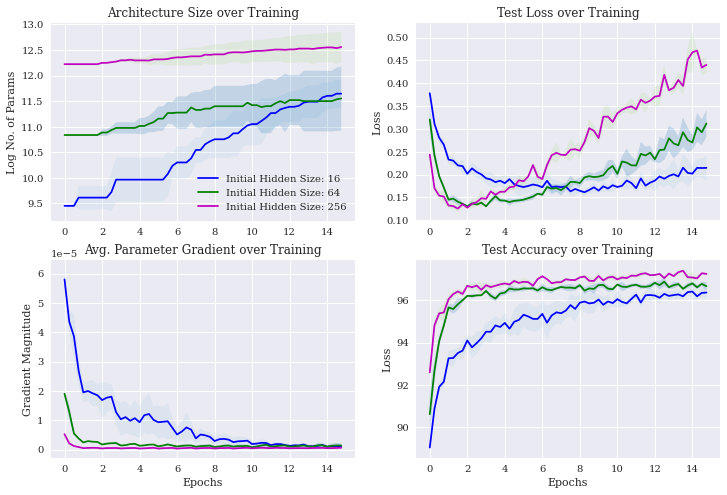

In [159]:
fig, ((axs1, axs2), (axs3, axs4)) = plt.subplots(2,2, figsize=(12,8))
x_axis = np.arange(0,num_epochs, .25)
# Plotting goes here
color = ["b", "g", "m", "r"]
keys = [16, 64, 256]
for i, key in enumerate(keys):
    acc_list_3 = []
    test_acc_3 = []
    loss_list_3 = []
    test_loss_3 = []
    model_size_3 = []
    grads_3 = []
    for j in range(3):
        (acc_list, test_acc, loss_list, test_loss, model_size, grads) = results3[key][-j]
        acc_list_3.append(acc_list)
        test_acc_3.append(test_acc)
        loss_list_3.append(loss_list)
        test_loss_3.append(test_loss)
        model_size_3.append(model_size)
        grads_3.append(grads)
    
    acc_list_mean = np.mean(acc_list_3, axis=0)
    test_acc_mean = np.mean(test_acc_3, axis=0)
    loss_list_mean = np.mean(loss_list_3, axis=0)
    test_loss_mean = np.mean(test_loss_3, axis=0)
    model_size_mean = np.mean(np.log(model_size_3), axis=0)
    grads_mean = np.mean(grads_3, axis=0)
    
    acc_list_std = np.std(acc_list_3, axis=0)
    test_acc_std = np.std(test_acc_3, axis=0)
    loss_list_std = np.std(loss_list_3, axis=0)
    test_loss_std = np.std(test_loss_3, axis=0)
    model_size_std = np.std(np.log(model_size_3), axis=0)
    grads_std = np.std(grads_3, axis=0)
        
    axs1.plot(x_axis, model_size_mean, color[i], label='Initial Hidden Size: ' + str(key))
    axs1.fill_between(x_axis, model_size_mean - model_size_std, model_size_mean + model_size_std, alpha=0.2)
    
    axs2.plot(x_axis, test_loss_mean, color[i])
    axs2.fill_between(x_axis, test_loss_mean - test_loss_std, test_loss_mean + test_loss_std, alpha=0.2)
    
#     axs2.plot(x_axis, loss_list, color[i] + "--")
#     axs2.plot(x_axis, loss_list)
    
    axs3.plot(x_axis, grads_mean, color[i])
    axs3.fill_between(x_axis, grads_mean - grads_std, grads_mean + grads_std, alpha=0.2)
    
    axs4.plot(x_axis, test_acc_mean, color[i])
    axs4.fill_between(x_axis, test_acc_mean - test_acc_std, test_acc_mean + test_acc_std, alpha=0.2)

# Formatting
axs1.title.set_text("Architecture Size over Training")
axs2.title.set_text("Test Loss over Training")
axs3.title.set_text("Avg. Parameter Gradient over Training")
axs4.title.set_text("Test Accuracy over Training")
axs1.legend()
axs1.set(ylabel="Log No. of Params")
axs2.set(ylabel="Loss")
axs3.set(xlabel='Epochs', ylabel="Gradient Magnitude")
axs4.set(xlabel='Epochs', ylabel="Loss")
fig.show()